In [1]:
!pip install tensorflow-gpu==2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf 

print("Tensorlfow Version: ", tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

Tensorlfow Version:  2.9.2


In [5]:
import os
os.chdir("/content/drive/MyDrive/CNN/House_classification/House Dataset")

In [6]:
!dir

Testing  Training  validation


In [ ]:
#!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 3.3 MB/s eta 0:00:00


In [ ]:
#import patoolib
#patoolib.extract_archive("House Dataset.rar")


In [7]:
# set the path to the train folder
train_path = "/content/drive/MyDrive/CNN/House_classification/House Dataset/Training"

# set the path to the validation folder
validation_path = "/content/drive/MyDrive/CNN/House_classification/House Dataset/validation"

#set the path to the test folder
test_path ="/content/drive/MyDrive/CNN/House_classification/House Dataset/Testing"

In [8]:
import shutil

In [9]:
# Set the percentage of images to use for validation
val_pct = 0.2

# Loop over the two subfolders in the train folder
for folder in os.listdir(train_path):
    # Create the corresponding subfolders in the validation folder
    os.makedirs(os.path.join(validation_path, folder))
    
    # Get the list of image files in the current folder
    files = os.listdir(os.path.join(train_path, folder))
    
    # Calculate the number of images to move to the validation folder
    num_val = int(len(files) * val_pct)
    
    # Move the images to the validation folder
    for file in files[:num_val]:
        src = os.path.join(train_path, folder, file)
        dst = os.path.join(validation_path, folder, file)
        shutil.move(src, dst)

In [10]:
# Config
CLASSES = ["House","Not House"]
# set the batch size when fine-tuning
BATCH_SIZE = 32

EPOCHS = 50
INIT_LR = 1e-3


In [12]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(train_path)))
totalvalidation = len(list(paths.list_images(validation_path)))
totalTest = len(list(paths.list_images(test_path)))
print(f"total number of pics in train {totalTrain}")
print(f"totat number of pics in  test {totalTest}")
print(f'total number of pics in validation {totalvalidation}')

total number of pics in train 354
totat number of pics in  test 111
total number of pics in validation 88


data Augmentation

In [13]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator( 
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator( 
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [14]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    train_path,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)


# initialize the testing generator
valGen = valAug.flow_from_directory(
    validation_path,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 354 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


# VGG16

In [40]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

In [41]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(250, activation="relu")(headModel)
headModel = Dense(len(CLASSES), activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
vgg_model = Model(inputs=baseModel.input, outputs=headModel)

In [42]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [43]:
from tensorflow.keras.optimizers import Adam

# ... other code ...

# create an instance of Adam optimizer
opt = Adam(lr=0.001)

In [44]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
#opt = SGD(lr=1e-4, momentum=0.9)
vgg_model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [45]:
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [46]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [47]:
# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [48]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = vgg_model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalTest // BATCH_SIZE,
    callbacks=early_stop,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/50
11/11 [==============================] - 18s 2s/step - loss: 5.5280 - accuracy: 0.8727 - val_loss: 15.3262 - val_accuracy: 0.9205
Epoch 2/50
11/11 [==============================] - 17s 2s/step - loss: 6.3643 - accuracy: 0.9472 - val_loss: 10.4376 - val_accuracy: 0.9318
Epoch 3/50
11/11 [==============================] - 17s 1s/step - loss: 2.7173 - accuracy: 0.9783 - val_loss: 7.7920 - val_accuracy: 0.9318
Epoch 4/50
11/11 [==============================] - 17s 2s/step - loss: 4.6527 - accuracy: 0.9565 - val_loss: 26.3138 - val_accuracy: 0.9091
Epoch 5/50
11/11 [==============================] - 17s 2s/step - loss: 1.4019 - accuracy: 0.9689 - val_loss: 18.3042 - val_accuracy: 0.9432
Epoch 6/50
11/11 [==============================] - 19s 2s/step - loss: 3.2347 - accuracy: 0.9689 - val_loss: 44.1632 - val_accuracy: 0.8977
Epoch 7/50
11/11 [==============================] - 17s 2s/step - loss: 5.0462 - accuracy: 0.9472 - val_loss: 11.5410 - val_accurac

In [50]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
valGen.reset()
predIdxs = vgg_model.predict(x=valGen,
    steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating after fine-tuning network head...
3/4 [=====================>........] - ETA: 0s

4/4 [==============================] - 3s 459ms/step


In [51]:
print(classification_report(valGen.classes, predIdxs,
    target_names=valGen.class_indices.keys()))


              precision    recall  f1-score   support

       House       0.96      0.92      0.94        52
   Not House       0.89      0.94      0.92        36

    accuracy                           0.93        88
   macro avg       0.93      0.93      0.93        88
weighted avg       0.93      0.93      0.93        88



In [54]:
def plot_acc(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot( H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("acc_output.png")

def plot_loss(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot( H.history["loss"], label="train_loss")
    plt.plot( H.history["val_loss"], label="val_loss")
   
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig("loss_output.png")

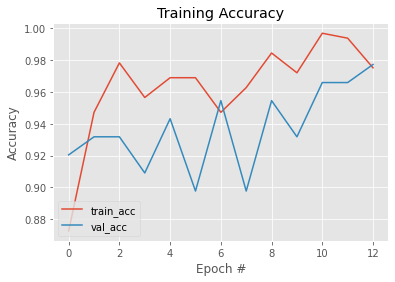

In [55]:
# plot training and val accuracy
plot_acc(H, EPOCHS)

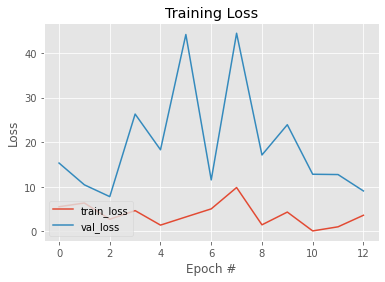

In [56]:
# plot training and val loss
plot_loss(H, EPOCHS)

In [84]:
# serialize the# serialize the model to disk

print("[INFO] serializing network...")
vgg_model.save("vgg_model_50epochs2.h5", save_format="h5")

[INFO] serializing network...


# Inference on Unseen Data

In [85]:
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [78]:
MODEL=vgg_model

In [81]:
!dir

acc_output.png	 Testing   validation
loss_output.png  Training  vgg_model_50epochs2.model


In [87]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model 
print("[INFO] loading network and...")
model = load_model("vgg_model_50epochs2.h5")

[INFO] loading network and...


[INFO] loading network and...


  0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


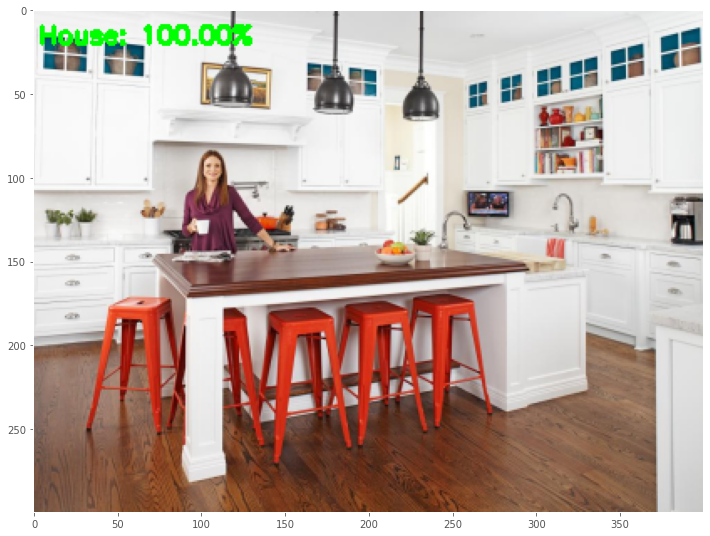

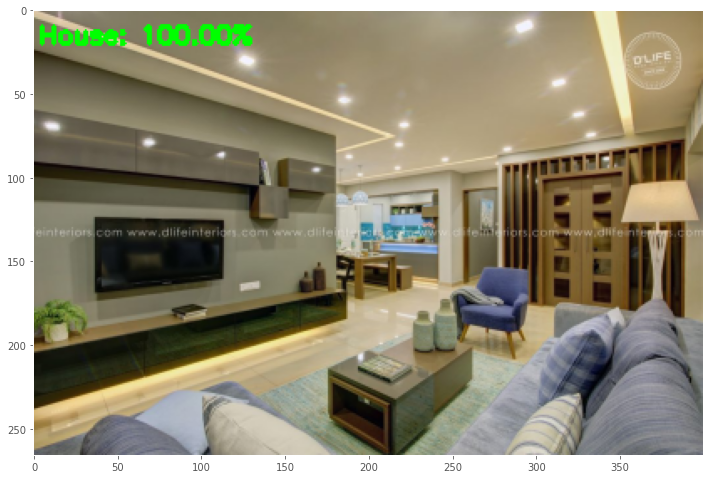

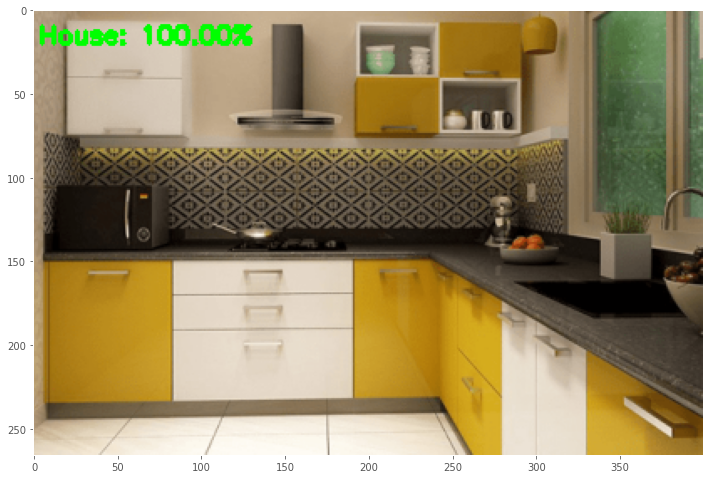

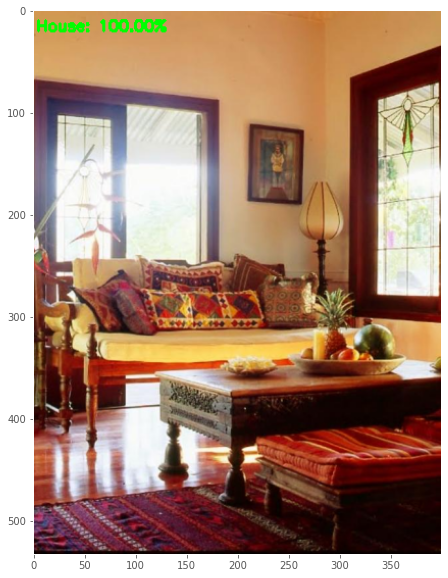

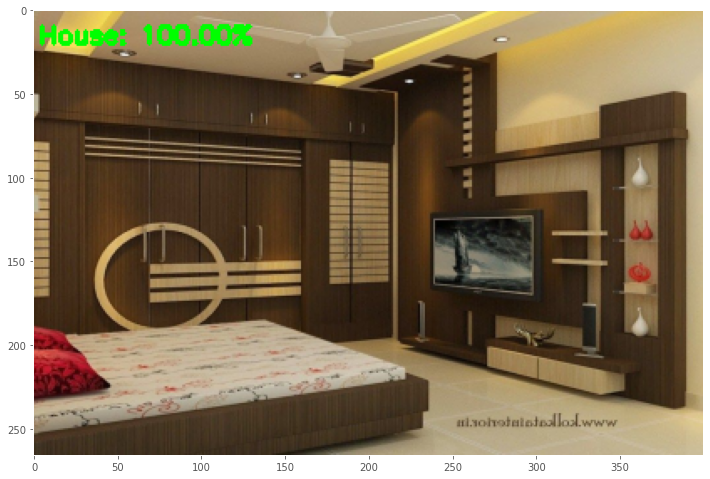

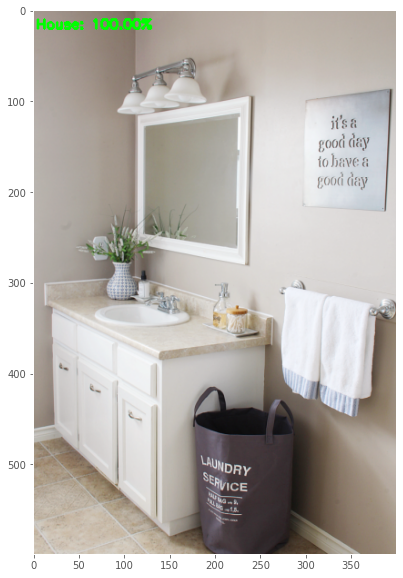

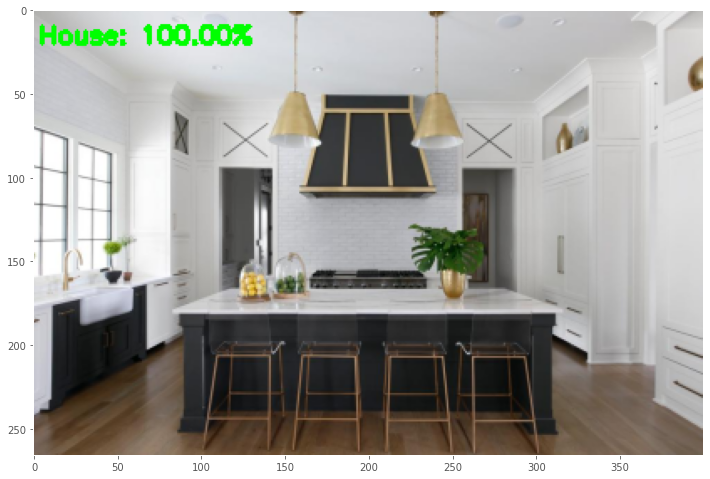

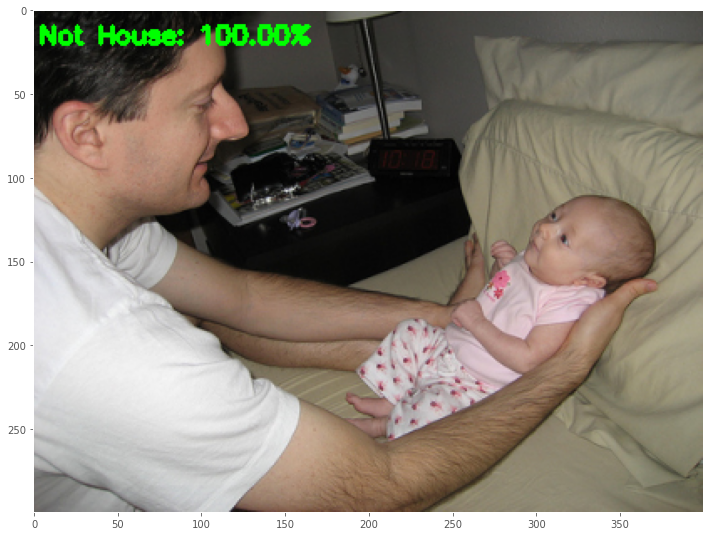

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model 
print("[INFO] loading network and...")
#model = load_model(MODEL)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/CNN/House_classification/House Dataset/Testing'))) 


# progress bar 
with tqdm(total=len(testImagePaths)) as pbar:
    
    for imagePath in testImagePaths:
        
        image = cv2.imread(imagePath)
        output = image.copy()
        output = imutils.resize(output, width=400)

        # our model was trained on RGB ordered images but OpenCV represents
        # images in BGR order, so swap the channels, and then resize to
        # 224x224 (the input dimensions for VGG16)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        # convert the image to a floating point data type and perform mean
        # subtraction
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        


        model = vgg_model

        # pass the image through the network to obtain our predictions
        preds = model.predict(np.expand_dims(image, axis=0))[0]
        i = np.argmax(preds)
        label = CLASSES[i]

        # draw the prediction on the output image
        text = "{}: {:.2f}%".format(label, preds[i] * 100)
        cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            (0, 255, 0), 2)
        
         # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)
